In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix
from random import sample, seed, shuffle
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA, KernelPCA, FastICA
import seaborn as sns
import datetime
from scipy import stats
import os

In [3]:
#Checking the PyTorch version installed
print(torch.__version__)

1.8.1


## 1. From raw data to a tidy dataset

In [4]:
# Loading the raw data
weather = pd.read_csv("/users/harsh/mtp/Detecting_anomalies_building_energy_usage/data/raw/weather.csv")
holidays = pd.read_csv("/users/harsh/mtp/Detecting_anomalies_building_energy_usage/data/raw/holidays.csv")
train = pd.read_csv("/users/harsh/mtp/Detecting_anomalies_building_energy_usage/data/raw/train.csv")
metadata = pd.read_csv("/users/harsh/mtp/Detecting_anomalies_building_energy_usage/data/raw/metadata.csv")

C:\Users\harsh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
train['meter_id'].unique()

array([2, 863, 869, 872, 875, 878, 881, 884, 887, 890, 896, 902, 911, 920,
       925, 928, 930, 935, 938, '938', '234_203', '334_61', '38_0',
       '38_1', '38_10106', '38_10107', '38_10108', '38_10109', '38_10110',
       '38_10111', '38_10112', '38_10113', '38_10114', '38_10115',
       '38_10116', '38_10117', '38_10118', '38_10119', '38_10120',
       '38_10121', '38_10122', '38_10123', '38_10124', '38_10125',
       '38_10126', '38_2', '38_52306', '38_52322', '38_52323', '38_52324',
       '38_52325', '38_52326', '38_52327', '38_52328', '38_52329',
       '38_52332', '38_52333', '38_52375', '38_52379', '38_52467',
       '38_52468', '38_52469', '38_52470', '38_52471', '38_52472',
       '38_52473', '38_52474', '38_52475', '38_52476', '38_52477',
       '38_52478', '38_52479', '38_52480', '38_52481', '38_52482',
       '38_56030', '38_56031', '38_56032', '38_56033', '38_56034',
       '38_56727', '38_56728', '38_56729', '38_56730', '38_56731',
       '38_56732', '38_56733', '38_56

In [6]:
train = train[train['meter_id'] == '38_9686']
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train['Weekday'] = train['Timestamp'].dt.weekday
train['Hour'] = train['Timestamp'].dt.hour
train['Month'] = train['Timestamp'].dt.month

In [7]:
# Some datasets have duplicates, this cell it take care of it
train = train.groupby(['Timestamp']).first()
train.reset_index(level=0, inplace=True)

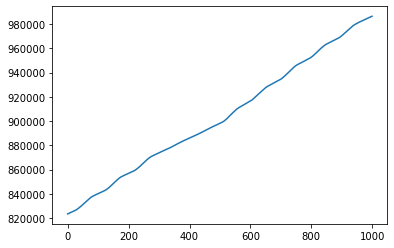

In [8]:
plt.plot(train['Values'].iloc[:1000])
plt.show()

In [9]:
# We take the difference of adjacent values of energy consumption since these values are cumulated 
train['ValuesDiff'] = 0
train['ValuesDiff'].iloc[1:-1] = train['Values'].iloc[1:-1].values - train['Values'].iloc[:-2].values

C:\Users\harsh\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


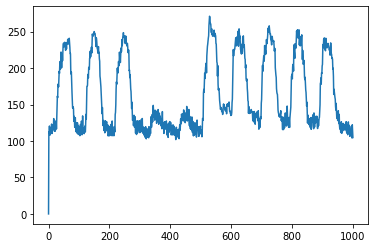

In [10]:
plt.plot(train.loc[:1000,'ValuesDiff'])
plt.show()

In [11]:
%matplotlib
train.plot(y='ValuesDiff',x='Timestamp')

Using matplotlib backend: Qt5Agg


<AxesSubplot:xlabel='Timestamp'>

#### 1.1 Adding the Holidays column

In [12]:
train['Date'] = train['Timestamp'].dt.strftime('%Y-%m-%d')
holidays = pd.DataFrame(
    holidays[holidays['site_id'] == "038"].groupby(['Date']).first())
holidays.reset_index(level=0, inplace=True)
train = train.merge(holidays, how='left', on = 'Date')
del train['Date']
train['Holiday'] = [isinstance(d, str)*1 for d in train['Holiday']]

#### 1.2 Adding the Temperature column

In [13]:
weather['Timestamp'] = pd.to_datetime(weather['Timestamp'])
weather['Date'] = weather['Timestamp'].apply(lambda dt: datetime.datetime(dt.year, 
                                                                      dt.month, 
                                                                      dt.day, 
                                                                      dt.hour))
weather = pd.DataFrame(
    weather[weather['site_id'] == "38"].groupby(['Date'])['Temperature'].mean())
weather.reset_index(level=0, inplace=True)
train['Date'] = train['Timestamp'].apply(lambda dt: datetime.datetime(dt.year, 
                                                                      dt.month, 
                                                                      dt.day, 
                                                                      dt.hour))
train = train.merge(weather, how='left', on='Date')
del train['Date']

#### 1.3 Determining buckets of energy consumption (for the predictive model below)

In [14]:
def consumption_label(x):
    if x >= np.percentile(train['ValuesDiff'], 99):
        return 'VeryHigh'
    elif x >= np.percentile(train['ValuesDiff'], 95):
        return 'High'
    elif x >= np.percentile(train['ValuesDiff'], 80):
        return 'MediumHigh'
    elif x >= np.percentile(train['ValuesDiff'], 60):
        return 'Medium'
    elif x >= np.percentile(train['ValuesDiff'], 40):
        return 'MediumLow'
    elif x >= np.percentile(train['ValuesDiff'], 20):
        return 'Low'
    elif x >= np.percentile(train['ValuesDiff'], 5):
        return 'VeryLow'
    elif x >= np.percentile(train['ValuesDiff'], 1):
        return 'StandBy'
    else:
        return 'Off'

In [15]:
# We chose to focus on the most recent years for our analysis, but it can surely run for all the dataset
train = train[train['Timestamp'] > "2016-01-01"]

In [16]:
train['ValuesDiff'] = train['ValuesDiff'].fillna(-1)
# Sometimes the meter resets, therefore we set the next value as NA, i.e., equal to -1
train.loc[train['ValuesDiff'] < -1e+06, 'ValuesDiff'] = -1
train['target'] = train['ValuesDiff'].apply(lambda row: consumption_label(row), 1)

#### 1.4 Handling temperature missing values

In [17]:
# Reseting indexes, this is important for the function that handles missing values
train.reset_index(inplace=True)

# Deleting some useless columns
del train['index']
del train['Unnamed: 0']
del train['row_id']
del train['site_id']

In [18]:
 def impute_values(indexes, x):
    """
    This function will be used to fill na's in the temperature column. It will firstly find add "blocks" 
    of na's, i.e, sequence of consecutives na's. Then, it interpolates the missing values by using the 
    temperature values before and after the beggining of the na block.
    
    Arguments:
        indexes: Pandas DataFrame of na's indexes
        x: the Pandas DataFrame column with temperatures
    """
    
    tmp = []
    
    blocks = []
    
    start_block = indexes[0]
    
    for idx in indexes:
        
        if start_block < 0:
            start_block = idx
        
        if (idx+1) in indexes:
            continue
        else:
            blocks.append([start_block, idx])
            start_block = -1
    
    tmp = np.array([])
    for begin, end in blocks:
        
        if begin == 0:
            last_val = x[end+1]
            next_val = x[end+1]
        elif end == len(x)-1:
            last_val = x[begin-1]
            next_val = x[begin-1]
        else:
            last_val = x[begin-1]
            next_val = x[end+1]

        imputation = np.repeat((last_val+next_val)/2, end-begin +1)
        
        tmp = np.concatenate((tmp, imputation))
    
    return tmp

In [19]:
train

,Timestamp,meter_id,Values,Weekday,Hour,Month,ValuesDiff,Holiday,Temperature,target
0,2016-01-01 00:15:00,38_9686,7.936775e+05,4,0,1,51.7500,1,5.0,Off
1,2016-01-01 00:30:00,38_9686,7.937304e+05,4,0,1,52.9375,1,5.0,Off
2,2016-01-01 00:45:00,38_9686,7.937929e+05,4,0,1,62.5000,1,5.0,StandBy
3,2016-01-01 01:00:00,38_9686,7.938486e+05,4,1,1,55.6875,1,5.0,Off
4,2016-01-01 01:15:00,38_9686,7.939012e+05,4,1,1,52.6250,1,5.0,Off
...,...,...,...,...,...,...,...,...,...,...
67619,2017-12-05 09:00:00,38_9686,1.062107e+06,1,9,12,368.3750,0,NaN,VeryHigh
67620,2017-12-05 09:15:00,38_9686,1.062506e+06,1,9,12,398.7500,0,NaN,VeryHigh
67621,2017-12-05 09:30:00,38_9686,NaN,1,9,12,-1.0000,0,NaN,Off
67622,2017-12-05 09:45:00,38_9686,NaN,1,9,12,-1.0000,0,NaN,Off


In [20]:
imputed_temperatures = impute_values(train[train['Temperature'].isnull()].index, 
                                     train['Temperature'])
train.loc[train['Temperature'].isnull(), 'Temperature'] = imputed_temperatures

#### 1.5 Pickling the dataset to gain some time for the next time

In [21]:
pickle.dump(train, open(os.path.join(os.getcwd(),'data\\train_prediction_38.pkl'), "wb"))

In [58]:
train = pickle.load(open(os.path.join(os.getcwd(),'data\\train_prediction_38.pkl'), "rb"))

In [59]:
train.plot(y='ValuesDiff',x='Timestamp')

<AxesSubplot:xlabel='Timestamp'>

## 2. Building the predictive model

#### 2.1 Preliminar steps

In [24]:
features = ['ValuesDiff', 'Holiday', 'Temperature', 'Weekday', 'Hour', 'Month']
feature_scaler = StandardScaler()
feature_scaler.fit(train[features])

StandardScaler()

In [25]:
def generate_df(df, sequence_length):
    """
    This function builds a tidy dataset to be used as input to a LSTM. 
    It returns a tensor of the shape [nb_records, 3*sequence_length+2, feature_size] and a vector
    of shape [nb_records] having the target values to predict.
    
    The main idea is to give the model an intraday pattern twice (two previous weeks) and an
    same but incomplete pattern for the current week so that the model has to predict only the
    last value of the pattern.
    
    Arguments:
        df: Pandas DataFrame containing the energy consumption data
        sequence_length: length of the pattern to recognize
    """
    
    target_labels = ['Off', 'StandBy', 'VeryLow', 'Low', 'MediumLow', 'Medium', 'MediumHigh', 'High','VeryHigh']
    target_labels = np.array(target_labels)
    
    X = []
    y = []
    
    for i in range(96*7*2, len(df) - sequence_length - 1):
        for j in range(3):
            if j == 0:
                tmp = feature_scaler.transform(df[features].iloc[i:(i+sequence_length)])
            else:
                ts = feature_scaler.transform(df[features].iloc[(i-j*96*7):(i+sequence_length-j*96*7+1)])
                tmp = np.concatenate((tmp, ts), axis=0)
            
        X.append(tmp)
        y.append(np.where(target_labels == df['target'].iloc[i+sequence_length + 1])[0][0])
        
    return np.array(X), np.array(y)

In [26]:
train_sequences, train_labels = generate_df(train, 8)
train_sequences.shape

(66271, 26, 6)

#### 2.2 Splitting train and test datasets

In [27]:
idx_train, idx_val, _, _ = train_test_split(list(range(train_sequences.shape[0])), 
                                         np.zeros(train_sequences.shape[0]), 
                                         test_size=0.5, 
                                         random_state=2018)

In [28]:
rnn_sequences = train_sequences[idx_train,:,:]
rnn_labels = train_labels[idx_train]

val_sequences = train_sequences[idx_val,:,:] 
val_labels = train_labels[idx_val]

#### 2.3 Defining the predictive model

In [29]:
def runValidation(model_dict, cm_print = False):
    model = WinticsRNN(hidden_size=hidden_size, 
                       features_size=len(features))
    
    model.load_state_dict(model_dict)    
    model.eval()
    
    sequences = torch.FloatTensor(val_sequences)
    sequences = autograd.Variable(sequences)
    
    labels_true = torch.LongTensor(val_labels)
    labels_true = autograd.Variable(labels_true)
    
    if torch.cuda.is_available():
        model.cuda()
        sequences = sequences.cuda()
        labels_true = labels_true.cuda()
    
    labels_predicted = model(sequences)
    loss = loss_function(labels_predicted, labels_true)
    
    _, labels_predicted = labels_predicted.max(1)
    labels_predicted = labels_predicted.data.cpu().numpy()
    
    if cm_print:
        print("Current Validation loss: %.3f" % loss.data.cpu().numpy())
        print(confusion_matrix(labels_predicted, val_labels))
    
    return accuracy_score(labels_predicted, val_labels)

In [30]:
class WinticsRNN(nn.Module):
    def __init__(self, hidden_size, features_size):
        super(WinticsRNN, self).__init__()
        self.hidden_size = hidden_size
        self.features_size = features_size
        
        self.rnn = nn.LSTM(self.features_size, 
                          self.hidden_size, 
                          1, # This argument stands for the nb of layers 
                          dropout=0, 
                          batch_first = True)
        
        self.fc = nn.Linear(self.hidden_size, 9)

    def forward(self, x):
        
        h0 = autograd.Variable(torch.zeros(1, x.size(0), self.hidden_size))
        c0 = autograd.Variable(torch.zeros(1, x.size(0), self.hidden_size))

        if torch.cuda.is_available():
            h0, c0 = h0.cuda(), c0.cuda()

        _, (x, _) = self.rnn(x, (h0, c0))
        
        x = torch.squeeze(x)
        x = self.fc(x)
        
        return x

#### 2.4 Training the model

In [31]:
nbEpochs = 282
hidden_size = 80
batch_size = 256

net = WinticsRNN(hidden_size=hidden_size, 
                 features_size=len(features))

#### Uncomment the following line if you want to retrain a previously saved model
# net.load_state_dict(torch.load("../Models/LSTM_80_38"))

if torch.cuda.is_available():
    net.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)
epoch_losses = []

best_model = net.state_dict()
epoch_acc_list = [] 

for ep in range(nbEpochs):

    avg_loss = []        
            
    net.train()

    for i in range(rnn_sequences.shape[0] // batch_size):
        
        X_batch = rnn_sequences[i*batch_size:(i+1)*batch_size, :, :]
        y_batch = rnn_labels[i*batch_size:(i+1)*batch_size]
        
        # [batch_size, sequence_length, features_size]
        sequences = torch.FloatTensor(X_batch)
        sequences = autograd.Variable(sequences)

        labels_true = torch.LongTensor(y_batch)
        labels_true = autograd.Variable(labels_true)
        
        if torch.cuda.is_available():
            sequences = sequences.cuda()
            labels_true = labels_true.cuda()
        
        labels_predicted = net(sequences)        
        
        net.zero_grad()
        loss = loss_function(labels_predicted, labels_true)
        loss.backward()    
        optimizer.step()

        avg_loss.append(loss.data.cpu().numpy()) 
    
    #<Early stopping>
    epoch_acc = runValidation(net.state_dict())
    epoch_acc_list.append(epoch_acc)

    if max(epoch_acc_list) <= epoch_acc:
        best_model = net.state_dict()

    if max(epoch_acc_list)/1.2 > epoch_acc:
        print("Training stopped by early stopping !")
        print("Validation MSE: %.2f" % (max(epoch_acc_list)))
        plt.plot(epoch_acc_list)
        plt.show()
        break
    #</Early stopping>
    
    if ep % 10 == 1:     
        print("Epoch losses: %.2f" % (np.mean(epoch_losses)))
        if ep % 40 == 1:
            print("Epoch nb: {}".format(ep))
            
            print("Validation Accuracy: %.2f" % runValidation(net.state_dict(), True))
            
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * 0.8
  
        epoch_losses = []
            
    epoch_losses.append(np.mean(avg_loss))

Epoch losses: 1.51
Epoch nb: 1
Current Validation loss: 0.984
[[   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [ 184 1105 3146  926   91   18    0    0    0]
 [  18  100 1416 3524  824  192    1    0    0]
 [  16   59  381 2132 5398 1233   99    4    0]
 [   5   47   18   52  413 4624 1301  134   30]
 [   2    0    0    0    0  654 3517 1162  310]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]]
Validation Accuracy: 0.61
Epoch losses: 0.92
Epoch losses: 0.84
Epoch losses: 0.81
Epoch losses: 0.79
Epoch nb: 41
Current Validation loss: 0.763
[[   0    0    0    0    0    0    0    0    0]
 [ 188  661  228   37   22    4    0    0    0]
 [  21  576 3384 1317   85   14    0    0    0]
 [   7   59 1090 3345  771   15    0    0    0]
 [   7   15  237 1813 5032  406    1    0    0]
 [   0    0   22  122  816 5816  943   10    0]
 [   1    0    0    0    0  466 3800  541   50]
 [   1    0    0    0  

In [32]:
torch.save(best_model, os.path.join(os.getcwd(),'data\\Model\\LSTM_80_38\\38.pth'))
best_model = torch.load(os.path.join(os.getcwd(),'data\\Model\\LSTM_80_38\\38.pth'))

In [57]:
best_model = torch.load(os.path.join(os.getcwd(),'data\\Model\\LSTM_80_38\\38.pth'))

#### 2.5 Evaluating the entropy of predictions

In [34]:
def entropy(model_dict, sequences, labels):
    """
    This function returns (i) the labels predicted by the model as well as (ii) the entropy 
    of predictions, which will serve as an indicator of the prediction's confidence.
    Small entropies mean that the model is sure of what it is predicting, regardless
    the target value.
    
    Arguments:
        model_dict: PyTorch model dictionary, i.e., the output of net.state_dict()
        sequences: RNN inputs, i.e., tensors of the form [nb_records, 3*sequence_length+2, feature_size]
        labels: Target values (only used for some metric evaluation)
    """
    model = WinticsRNN(hidden_size=hidden_size, 
                       features_size=len(features))
    
    model.load_state_dict(model_dict)
    model.eval()
    
    sequences = torch.FloatTensor(sequences)
    sequences = autograd.Variable(sequences)
    
    labels_true = torch.LongTensor(labels)
    labels_true = autograd.Variable(labels_true)

    if torch.cuda.is_available():
        model.cuda()
        sequences = sequences.cuda()
        labels_true = labels_true.cuda()

    labels_predicted = model(sequences)
    
    entropy = [exp_logits/torch.sum(exp_logits) for exp_logits in torch.exp(labels_predicted)]
    entropy = [-torch.log(probs).dot(probs) for probs in entropy]
    entropy = np.array([e.data.cpu().numpy() for e in entropy])
    
    _, labels_predicted = labels_predicted.max(1)
    labels_predicted = labels_predicted.data.cpu().numpy()
    
    print("Dataset accuracy: %.3f" % accuracy_score(labels_predicted, labels))
    cm = confusion_matrix(labels_predicted, labels)
    extended_diagonal = cm.trace()+cm[1:, :-1].trace()+cm[:-1, 1:].trace()
    extended_diagonal_2 = extended_diagonal+cm[2:, :-2].trace()+cm[:-2, 2:].trace()
    
    print("Dataset extended accuracy (max gap 1): %.3f" % (extended_diagonal/np.sum(cm)))
    print("Dataset extended accuracy (max gap 2): %.3f" % (extended_diagonal_2/np.sum(cm)))
    
    return labels_predicted, entropy

In [60]:
# Calculating the entropies for the training dataset
overconsumption_train, entropy_train = entropy(best_model, rnn_sequences, rnn_labels)

Dataset accuracy: 0.752
Dataset extended accuracy (max gap 1): 0.993
Dataset extended accuracy (max gap 2): 0.999


In [61]:
# Calculating the entropies for the test dataset
overconsumption_val, entropy_val = entropy(best_model, val_sequences, val_labels)

Dataset accuracy: 0.746
Dataset extended accuracy (max gap 1): 0.992
Dataset extended accuracy (max gap 2): 0.999


In [62]:
# Creating a column 'entropy' in the original dataset 
train['entropy'] = 3.0
train.loc[96*7*2+8+1+np.array(idx_val),'entropy'] = entropy_val[:]
train.loc[96*7*2+8+1+np.array(idx_train), 'entropy'] = entropy_train[:]

In [63]:
# Creating a column 'predicted' in the original dataset
target_labels = ['Off', 'StandBy', 'VeryLow', 'Low', 'MediumLow', 'Medium', 'MediumHigh', 'High','VeryHigh']
train['predicted'] = "None"
train.loc[96*7*2+8+1+np.array(idx_val), 'predicted'] = [target_labels[v] for v in overconsumption_val]
train.loc[96*7*2+8+1+np.array(idx_train), 'predicted'] = [target_labels[v] for v in overconsumption_train]

#### 2.6 Determining the anomaly score

In [64]:
def get_gap(row):
    """
    This function returns the number of buckets lying between the prediction and the target value.
    It will be applied to all the main dataset's lines.
    
    Arguments:
        row: row of the dataset.
    """
    if row['predicted'] in target_labels:
        idx_pred = np.where(np.array(target_labels) == row['predicted'])[0][0]
        idx_true = np.where(np.array(target_labels) == row['target'])[0][0]

        return idx_true - idx_pred
    else:
        return 0

In [65]:
train['gap'] = train.apply(lambda row: get_gap(row), 1)

##### CRITERIA : the anomaly score

The main motivation for that anomaly score is to catch two behaviours :

    - Low entropy and low prediction gap:
        The model is sure of what it is predicting, and still, there is a gap. This effect
        increases the risk that the current measurement is actually an anomaly.
    - Moderate enropy and high prediction gap:
        If the gap is somehow higher than what the entropy measurement is expecting,
        then the this energy measurement is a potential anomaly.

Since there are 9 buckets, the maximum entropy we can possibly get is ln(9), which is about 2.2.

Let's consider an arbitrary prediction. Suppose that its entropy is equal to 0.69, then, 
the mass of probabilities is very likely distributed to only 2 buckets (because ln(2) is about 0.69). 
Suppose that the gap between the prediction and the target value is 3. We have then a suspicious
energy measurement: the probabilities are very high for only two buckets (probably one next 
to the other), and still the target value is 3 buckets away from the prediction.

The same logic can be drawn for all gaps. I came up with the following formula:
$$gap*exp(ln(9)-entropy)$$

It will have high absolute values whenever something unexpected happens.

In [66]:
train['criteria'] = train['gap']*np.exp(3 - train['entropy'])

#### 2.7 Rule-based approach (Percentiles)

In [67]:
train['temp_bucket'] = train['Temperature'].apply(lambda row: np.round(row/5)*5)
train['working_day'] = (train['Weekday'] < 5)&(train['Holiday'] == 0)

In [68]:
def get_percentile(row):
    """
    This function returns the percentile of the energy consumption measurement with respect
    to (i) the Temperature, (ii) the type of day and (iii) the hour.
    
    Arguments:
        row: row of the dataset.
    """
    bucket = row['temp_bucket']
    weekday = row['working_day']
    hour = row['Hour']
    
    cond = (train['temp_bucket'] == bucket)&(train['working_day'] == weekday)&(train['Hour'] == hour)    
    range_of_values = train.loc[cond, 'ValuesDiff']
    
    return stats.percentileofscore(range_of_values, row['ValuesDiff'])

In [69]:
train['percentile'] = train.apply(lambda row: get_percentile(row), 1)

#### 2.8 Rule-based approach (Checking the context)

In [70]:
 def check_context(idx):
    """
    The main idea of that function is to detect and eliminate anomalies that come from abnormal
    contexts. For instance, if there is a conference takes place in the building for an entire
    week, the energy consumption levels will be higher than the 'normal' days but it won't
    necessarily be classified as overconsumption. So the idea is to detect these kind of weeks 
    and ignore any alarm that the predictive model might throw in that period of time.
    
    This function checks whether the pattern of a certain meter neighbourhood value is high 
    across the entire week. It compares the pattern percentiles for the precedent week against
    the two former weeks. It returns the number of days it went higher.
    
    Arguments:
        idx: index of the meter measurement, i.e., dataset row.
    """
    ans = 0
    
    for j in range(7):
        week_n   = train.loc[idx-8-j*96       :idx+8-j*96, 'percentile'].mean()
        week_n_1 = train.loc[idx-8-j*96-96*7*1:idx+8-j*96-96*7*1, 'percentile'].mean()
        week_n_2 = train.loc[idx-8-j*96-96*7*2:idx+8-j*96-96*7*2, 'percentile'].mean()
        
        ans += (week_n > week_n_1 + 10)*1 + (week_n > week_n_2 + 10)*1
    
    return ans

In [71]:
# Here is an illustration of what can be detected by this model

fig, ax1 = plt.subplots(figsize=(16, 8))
begin = 55234-96
end = 55234+1+96
consumption = train.loc[begin:end, 'ValuesDiff'].values - train.loc[begin:end, 'ValuesDiff'].min()
consumption = 100*consumption/(train.loc[begin:end, 'ValuesDiff'].max()-train.loc[begin:end, 'ValuesDiff'].min())
slide = 55234
ax1.plot(train.loc[begin:end, 'percentile'].values)
ax1.plot(consumption, color = "green")
ax1.set_ylim([0, 100])
ax2 = ax1.twinx()
ax2.plot(train.loc[begin:end, 'criteria'].values, color="red", linestyle=":", linewidth=3)
ax2.set_ylim([-16, 16])
plt.show()

#### 2.9 The algorithm

Two modifications have been done for this site since there is no measurement with criteria > 11.

<li>Criteria Threshold: 6 (instead of 11)</li>
<li>Anomaly duration: at least half hour (instead of at least an hour) </li>

In [102]:
# Initialization
train['is_abnormal'] = False

# Detecting the beggining of anomalies (Prediction-Based approach)
train.loc[train['criteria']>6, 'is_abnormal'] = True

# Filtering process (Rule-based approach)
for idx in train[train['is_abnormal']].index:
    
    # Eliminating abnormal energy consumption contexts
    if check_context(idx) > 8:
        train.loc[idx, 'is_abnormal'] = False
        continue
        
    # Eliminating low percentile anomalies
    if train.loc[idx, 'percentile'] < 90:
        train.loc[idx, 'is_abnormal'] = False
        continue
    
    # Eliminating anomalies that come just after na values
    if train.loc[idx-5:idx-1, 'Values'].min() < 0:
        train.loc[idx, 'is_abnormal'] = False
        continue
    
    # Anomalies should begin just after a ascending percentile pattern
    if train.loc[idx-5:idx-1, 'percentile'].mean() >= 80:
        train.loc[idx, 'is_abnormal'] = False

# Extending the duration of the anomalies
for idx in train[train['is_abnormal']].index:
    k=0
    moving_average = train.loc[idx, 'percentile']
    while (moving_average >= 80):
        train.loc[idx+k, 'is_abnormal'] = True
        k+=1
        moving_average = 0.2*moving_average + 0.8*train.loc[idx+k, 'percentile']

    # Eliminating anomalies that last less than half an hour
    if k < 2:
        train.loc[idx:idx+k, 'is_abnormal'] = False

In [103]:
sum(train['is_abnormal'])

1750

#### 2.10 Illustration of the anomalies found

In [104]:
fig, ax1 = plt.subplots(figsize=(16, 8))
anamolyno=12
begin = 55234-48
end = 55234+1+48
ax1.plot(train.loc[begin:end, 'percentile'])
ax1.plot(train[train['is_abnormal']].loc[begin:end, 'percentile'], color = "green", linewidth=10, linestyle=":")
ax1.set_ylim([0, 100])
ax2 = ax1.twinx()
ax2.plot(train.loc[begin:end, 'criteria'], color="red")
ax2.set_ylim([-16, 16])
plt.show()

In [117]:
anamolyno=2
fig, ax1 = plt.subplots(figsize=(16, 8))
slide = train.loc[train['is_abnormal']==True].index[anamolyno]
begin = slide-96
end = slide+1+96
consumption = train.loc[begin:end, 'ValuesDiff'].values - train.loc[begin:end, 'ValuesDiff'].min()
consumption = 100*consumption/(train.loc[begin:end, 'ValuesDiff'].max()-train.loc[begin:end, 'ValuesDiff'].min())
timestamp=train.loc[begin:end,'Timestamp']
ax1.plot(timestamp,train.loc[begin:end, 'percentile'].values)
ax1.plot(timestamp,consumption, color = "green")
ax1.set_ylim([0, 100])
ax2 = ax1.twinx()
ax2.plot(timestamp,train.loc[begin:end, 'criteria'].values, color="red", linestyle=":", linewidth=3)
plt.show()

In [105]:
train.plot(x='Timestamp',y='v')

<AxesSubplot:xlabel='Timestamp'>

In [106]:
train

,Timestamp,meter_id,Values,Weekday,Hour,Month,ValuesDiff,Holiday,Temperature,target,entropy,predicted,gap,criteria,temp_bucket,working_day,percentile,is_abnormal,v,t
0,2016-01-01 00:15:00,38_9686,7.936775e+05,4,0,1,51.7500,1,5.0,Off,3.000000,None,0,0.000000,5.0,False,0.534759,False,NaN,0.0
1,2016-01-01 00:30:00,38_9686,7.937304e+05,4,0,1,52.9375,1,5.0,Off,3.000000,None,0,0.000000,5.0,False,2.673797,False,121.474940,0.0
2,2016-01-01 00:45:00,38_9686,7.937929e+05,4,0,1,62.5000,1,5.0,StandBy,3.000000,None,0,0.000000,5.0,False,5.347594,False,1128.984652,0.0
3,2016-01-01 01:00:00,38_9686,7.938486e+05,4,1,1,55.6875,1,5.0,Off,3.000000,None,0,0.000000,5.0,False,5.612245,False,-606.993750,0.0
4,2016-01-01 01:15:00,38_9686,7.939012e+05,4,1,1,52.6250,1,5.0,Off,3.000000,None,0,0.000000,5.0,False,2.040816,False,-289.407969,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67619,2017-12-05 09:00:00,38_9686,1.062107e+06,1,9,12,368.3750,0,-5.7,VeryHigh,1.044054,VeryHigh,0,0.000000,-5.0,True,80.434783,False,-997.251568,0.0
67620,2017-12-05 09:15:00,38_9686,1.062506e+06,1,9,12,398.7500,0,-5.7,VeryHigh,1.051636,VeryHigh,0,0.000000,-5.0,True,92.391304,False,3287.962335,0.0
67621,2017-12-05 09:30:00,38_9686,NaN,1,9,12,-1.0000,0,-5.7,Off,1.057056,VeryHigh,-8,-55.834158,-5.0,True,1.630435,False,100.250784,-0.0
67622,2017-12-05 09:45:00,38_9686,NaN,1,9,12,-1.0000,0,-5.7,Off,1.055175,VeryHigh,-8,-55.939254,-5.0,True,1.630435,False,-0.000000,-0.0


In [111]:
train['v']=train['ValuesDiff'].pct_change()*100*train['ValuesDiff']
train.loc[train['is_abnormal']==True,'t']=1
train.loc[train['is_abnormal']==False,'t']=0
train['t']=train['t']*train['ValuesDiff']

In [115]:
%matplotlib
anamolyno=12
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(train['Timestamp'],train['ValuesDiff'],color = "green")
#ax1.set_ylim([0, 100])
ax2 = ax1.twinx()
ax2.scatter(train['Timestamp'],train['t'], color="red",)
plt.show()

Using matplotlib backend: Qt5Agg
